# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band2.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.008209  0.145693 -0.263339  0.093509  0.228191 -0.211394   
      201547 -0.481517  0.153770  0.247627  0.599937 -0.074111  0.448611   
      201548  0.021916  0.079716  0.111925 -0.484560  0.064968 -0.013556   
      201549  0.645270  0.106736  0.871938  0.181424 -0.161637 -0.428532   
      201550 -0.426889 -0.149734  0.283259  0.152032  0.293191  0.062389   

                     6         7         8         9  ...      1015      1016  \
41001 201546  0.062259 -0.253796 -0.792625 -0.186645  ... -0.075539  0.187303   
      201547  0.101411 -0.101133  0.418422  0.072707  ... -0.057966  0.019604   
      201548  0.038336 -0.183089  0.366045 -0.155894  ... -0.633231  0.729808   
      201549 -0.511301 -0.131637  0.101343 -0.362995  ... -0.354475 -0.108382   
      201550 -0.370870  0.150521 -0.243733  0.249990  ... -0.390793 -0.305084   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.426474 -0.431914 -0.026159 -0.283616  0.169170 -0.084219   
      201547  0.474021 -0.058589  0.129858  0.276862  0.453937  0.493795   
      201548  0.215805  0.331432  0.193200  0.367620 -0.204150  0.193621   
      201549  0.201724  0.343165  0.169714  0.105122  0.272584  0.230635   
      201550  0.609258  0.440609  0.645534  0.097735 -0.087922  0.049879   

                  1023    Labels  
41001 201546 -0.005707 -0.861740  
      201547 -0.143907 -0.854589  
      201548  0.371088 -0.856973  
      201549  0.491422 -0.856973  
      201550  0.194685 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.095260 -0.794750 -0.334572  0.066084  0.422956 -0.624978   
      201821 -0.901951 -0.348315  0.023932  0.012976  0.083323  0.239934   
      201822 -0.108088 -0.049418  0.036500 -0.451850  0.442480  0.519660   
      201823  0.313301 -0.607704 -0.140003  0.079596 -0.199033  0.415212   
      201824  0.328018 -0.482813  0.230468  0.186436  0.403388 -0.084415   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.076410 -0.022807 -0.313250  0.131971  ...  0.487678  0.155330   
      201821 -0.453513 -0.437285 -0.204959  0.385104  ... -0.320209  0.469984   
      201822 -0.026942  0.309870  0.213743  0.289390  ...  0.036715 -0.377742   
      201823 -0.452376  0.434946 -0.125985 -0.153426  ...  0.147744  0.233628   
      201824 -0.437604  0.474747 -0.289463 -0.156414  ... -0.289661 -0.043722   

                  1017      1018      1019      1020      1021      1022  \
41001 201820  0.336210  0.476140  0.219473 -0.014431 -0.117069  0.106061   
      201821  0.251053 -0.119247 -0.556329 -0.253917  0.085193  0.159698   
      201822 -0.181748 -0.245964 -0.134193  0.691725 -0.183842 -1.016807   
      201823  0.893168  0.063706 -0.229148 -0.438158  0.317040 -0.521128   
      201824  0.296210  0.047754  0.073472 -0.195985 -0.627216 -0.338784   

                  1023    Labels  
41001 201820 -0.416483 -0.949940  
      201821  0.088116 -0.961859  
      201822 -0.232585 -0.940405  
      201823 -0.084477 -0.961859  
      201824 -0.160342 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

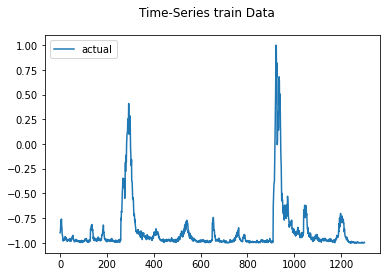

2023-03-14 15:33:54.240566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 15:33:54.240601: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 15:33:54.240624: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 15:33:54.240832: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 15:33:54.311223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 38.683
Test RMSE: 47.127
Test sMAPE: 102.749
Test R Squared: -1.298
{'mae': 38.68266001108921, 'rmse': 47.12672108596582, 'smape': 102.7488476892861, 'r2': -1.2981398306870626}


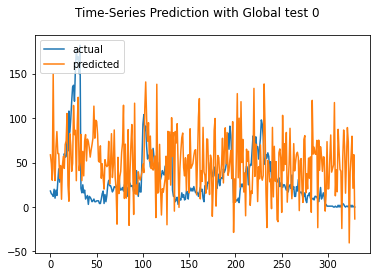

Test MAE: 39.868
Test RMSE: 51.329
Test sMAPE: 116.541
Test R Squared: -1.726
{'mae': 39.8678040302161, 'rmse': 51.328656584975455, 'smape': 116.54081750796908, 'r2': -1.726225634198197}


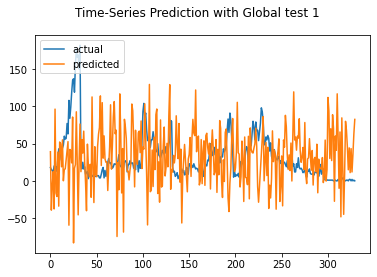

Test MAE: 74.526
Test RMSE: 82.221
Test sMAPE: 119.760
Test R Squared: -5.995
{'mae': 74.5263006065831, 'rmse': 82.22105910779916, 'smape': 119.75954114541825, 'r2': -5.9953288443129455}


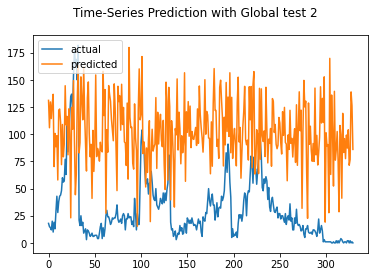

Test MAE: 39.631
Test RMSE: 48.581
Test sMAPE: 99.478
Test R Squared: -1.442
{'mae': 39.63122623291883, 'rmse': 48.58075559439932, 'smape': 99.4776243343362, 'r2': -1.442139860368672}


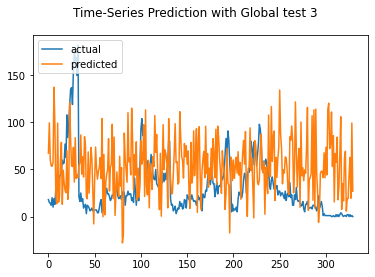

Test MAE: 62.792
Test RMSE: 72.352
Test sMAPE: 111.036
Test R Squared: -4.417
{'mae': 62.7924844344457, 'rmse': 72.35156167571915, 'smape': 111.03561412295885, 'r2': -4.416737887676979}


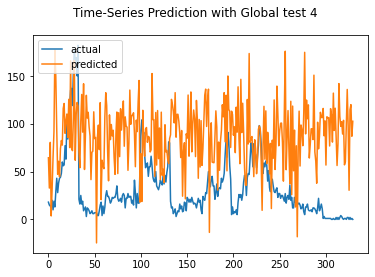

Test MAE: 46.694
Test RMSE: 55.782
Test sMAPE: 101.745
Test R Squared: -2.220
{'mae': 46.694031869642664, 'rmse': 55.781813474998025, 'smape': 101.74533483538178, 'r2': -2.2197878701495335}


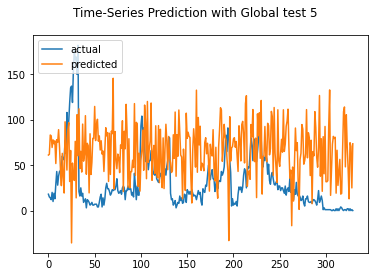

Test MAE: 48.490
Test RMSE: 58.437
Test sMAPE: 103.362
Test R Squared: -2.534
{'mae': 48.49007739876256, 'rmse': 58.436766564279964, 'smape': 103.36150462720744, 'r2': -2.5335753493259}


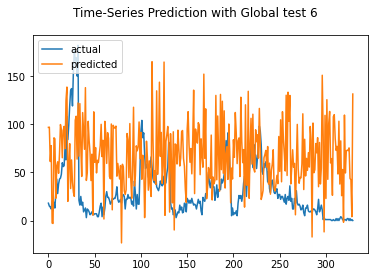

Test MAE: 48.705
Test RMSE: 57.760
Test sMAPE: 107.282
Test R Squared: -2.452
{'mae': 48.70471436724518, 'rmse': 57.76000132390106, 'smape': 107.28236599651967, 'r2': -2.4522035172401204}


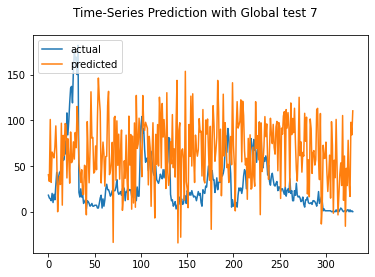

Test MAE: 43.038
Test RMSE: 52.294
Test sMAPE: 102.137
Test R Squared: -1.830
{'mae': 43.03834471034281, 'rmse': 52.293976812810044, 'smape': 102.137145211124, 'r2': -1.8297322318872555}


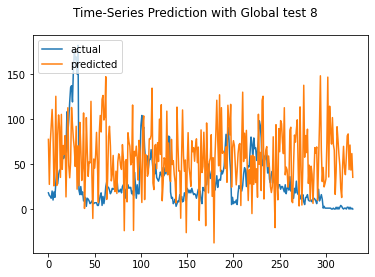

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 39.539
Test RMSE: 51.031
Test sMAPE: 116.699
Test R Squared: -1.695
{'mae': 39.53866156411893, 'rmse': 51.03060802683979, 'smape': 116.6986291556291, 'r2': -1.6946569715647666}


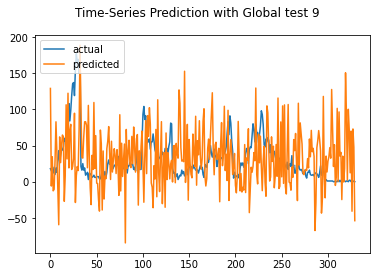

Test MAE: 63.409
Test RMSE: 71.440
Test sMAPE: 112.735
Test R Squared: -4.281
{'mae': 63.408758896047416, 'rmse': 71.43965564510502, 'smape': 112.73461985073293, 'r2': -4.281055196209382}


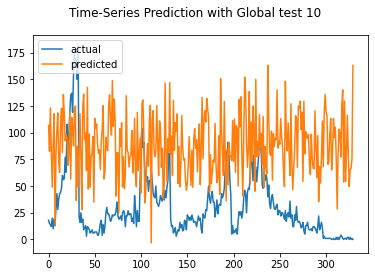

Test MAE: 53.938
Test RMSE: 62.125
Test sMAPE: 106.598
Test R Squared: -2.994
{'mae': 53.93761389472268, 'rmse': 62.12527578474575, 'smape': 106.59815752722551, 'r2': -2.9937296353290597}


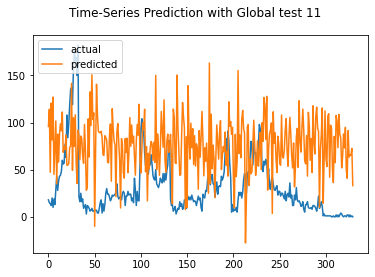

Test MAE: 47.719
Test RMSE: 57.226
Test sMAPE: 101.470
Test R Squared: -2.389
{'mae': 47.71896649273959, 'rmse': 57.22645858995452, 'smape': 101.46987749622429, 'r2': -2.388720448076453}


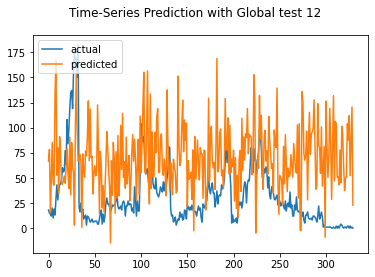

Test MAE: 51.271
Test RMSE: 59.302
Test sMAPE: 106.960
Test R Squared: -2.639
{'mae': 51.271370473594374, 'rmse': 59.30155628561744, 'smape': 106.9599289035701, 'r2': -2.6389340402360193}


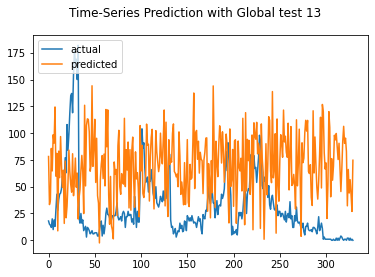

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 51.238
Test RMSE: 63.052
Test sMAPE: 112.497
Test R Squared: -3.114
{'mae': 51.23845273202116, 'rmse': 63.052290680247424, 'smape': 112.497278528334, 'r2': -3.1138053606093807}


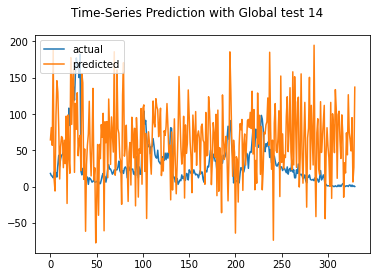

Test MAE: 33.656
Test RMSE: 43.635
Test sMAPE: 94.919
Test R Squared: -0.970
{'mae': 33.6563644591606, 'rmse': 43.63549127711211, 'smape': 94.91855124773137, 'r2': -0.9702518386835086}


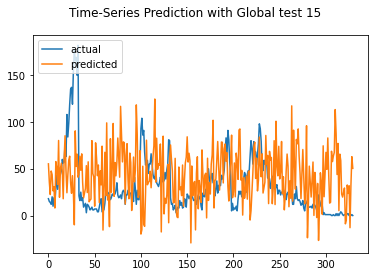

Test MAE: 61.718
Test RMSE: 70.182
Test sMAPE: 111.456
Test R Squared: -4.097
{'mae': 61.71840997320233, 'rmse': 70.18207838374349, 'smape': 111.45620185588707, 'r2': -4.096763152813692}


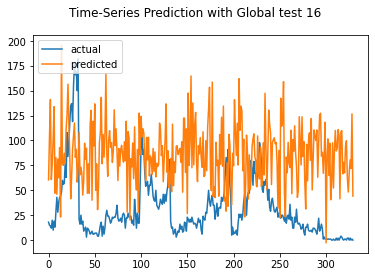

Test MAE: 46.447
Test RMSE: 56.199
Test sMAPE: 102.870
Test R Squared: -2.268
{'mae': 46.44657011032105, 'rmse': 56.19878657420948, 'smape': 102.86987406399024, 'r2': -2.2681040767460803}


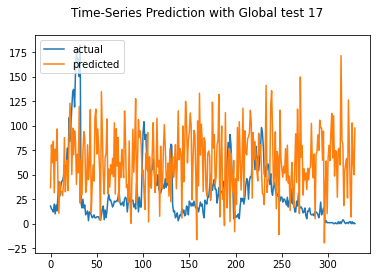

Test MAE: 34.798
Test RMSE: 44.040
Test sMAPE: 108.972
Test R Squared: -1.007
{'mae': 34.79815613121698, 'rmse': 44.04039859874129, 'smape': 108.97173190185264, 'r2': -1.0069866500442046}


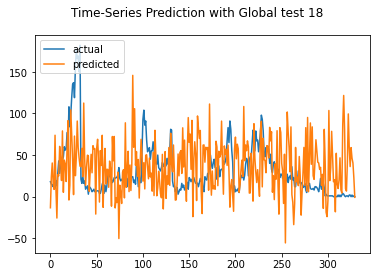

Test MAE: 51.807
Test RMSE: 62.372
Test sMAPE: 108.023
Test R Squared: -3.026
{'mae': 51.806859253753316, 'rmse': 62.372123682590356, 'smape': 108.02332827043439, 'r2': -3.025529971763196}


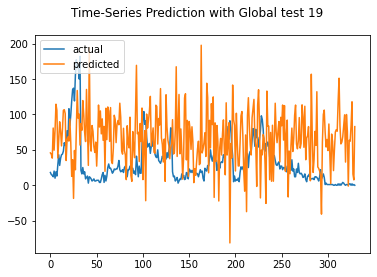

Test MAE: 46.175
Test RMSE: 54.572
Test sMAPE: 104.131
Test R Squared: -2.082
{'mae': 46.17454727418495, 'rmse': 54.572299033677126, 'smape': 104.13092676519922, 'r2': -2.0816726365832947}


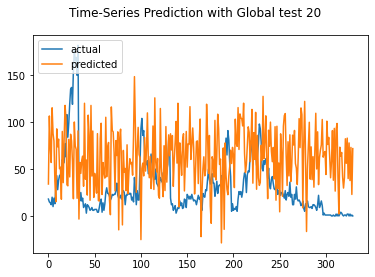

Test MAE: 47.394
Test RMSE: 57.545
Test sMAPE: 106.534
Test R Squared: -2.427
{'mae': 47.39421805143356, 'rmse': 57.54462182468444, 'smape': 106.53375269864225, 'r2': -2.426505886443618}


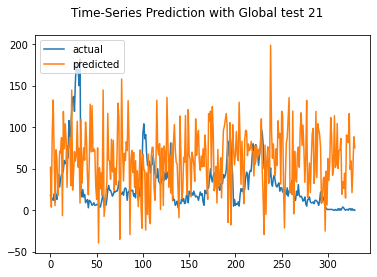

Test MAE: 39.674
Test RMSE: 47.828
Test sMAPE: 97.825
Test R Squared: -1.367
{'mae': 39.67423900853504, 'rmse': 47.8281569603054, 'smape': 97.82469645715489, 'r2': -1.3670601460060547}


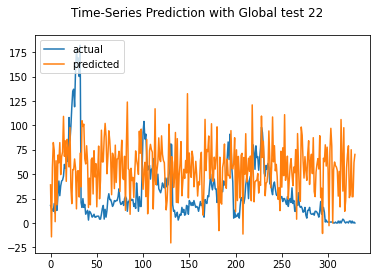

Test MAE: 39.800
Test RMSE: 50.167
Test sMAPE: 98.207
Test R Squared: -1.604
{'mae': 39.79992151061694, 'rmse': 50.16662915734652, 'smape': 98.20749443465283, 'r2': -1.6041850575077268}


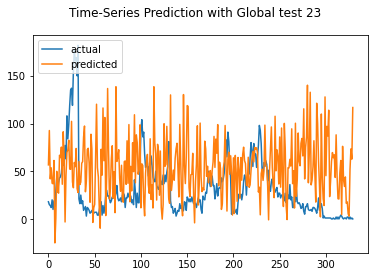

Test MAE: 38.225
Test RMSE: 50.146
Test sMAPE: 140.233
Test R Squared: -1.602
{'mae': 38.224867553602564, 'rmse': 50.14645145105089, 'smape': 140.23331445541245, 'r2': -1.602090600907609}


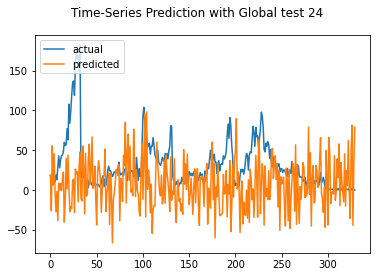

Test MAE: 51.494
Test RMSE: 61.205
Test sMAPE: 107.209
Test R Squared: -2.876
{'mae': 51.493683930238085, 'rmse': 61.205265973550325, 'smape': 107.20937066748672, 'r2': -2.876319632181497}


Test MAE: 44.767
Test RMSE: 55.110
Test sMAPE: 99.713
Test R Squared: -2.143
{'mae': 44.7665831063733, 'rmse': 55.10989999470006, 'smape': 99.71274543480399, 'r2': -2.142687857371723}


Test MAE: 49.248
Test RMSE: 60.036
Test sMAPE: 104.430
Test R Squared: -2.730
{'mae': 49.24760879603299, 'rmse': 60.03583538996432, 'smape': 104.4299511153554, 'r2': -2.729607400913089}


Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 51.475
Test RMSE: 64.569
Test sMAPE: 113.969
Test R Squared: -3.314
{'mae': 51.475472352360235, 'rmse': 64.56874820693544, 'smape': 113.96924218188943, 'r2': -3.3140655065343383}


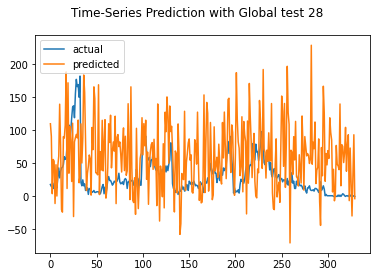

Test MAE: 36.713
Test RMSE: 45.987
Test sMAPE: 108.132
Test R Squared: -1.188
{'mae': 36.71286912614649, 'rmse': 45.98657769905832, 'smape': 108.132145002429, 'r2': -1.1882865105731657}


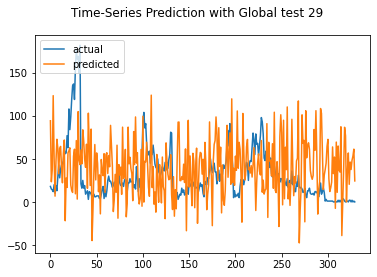

Test MAE: 54.329
Test RMSE: 62.995
Test sMAPE: 107.427
Test R Squared: -3.106
{'mae': 54.32940500757911, 'rmse': 62.9954592296552, 'smape': 107.42665230926734, 'r2': -3.1063928412532933}


Test MAE: 38.671
Test RMSE: 47.822
Test sMAPE: 95.888
Test R Squared: -1.366
{'mae': 38.67116709333477, 'rmse': 47.822113715789584, 'smape': 95.88757858039321, 'r2': -1.3664620121689728}


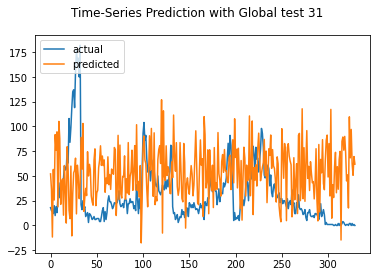

Test MAE: 39.674
Test RMSE: 47.121
Test sMAPE: 98.458
Test R Squared: -1.298
{'mae': 39.6744052995335, 'rmse': 47.12072695353117, 'smape': 98.45775580034969, 'r2': -1.2975552587870873}


Test MAE: 56.497
Test RMSE: 65.293
Test sMAPE: 110.350
Test R Squared: -3.411
{'mae': 56.497138564514394, 'rmse': 65.29289703206831, 'smape': 110.35025691049609, 'r2': -3.4113739964049437}


Test MAE: 39.441
Test RMSE: 48.578
Test sMAPE: 98.413
Test R Squared: -1.442
{'mae': 39.44077256610899, 'rmse': 48.57841735581043, 'smape': 98.41309215033843, 'r2': -1.4419047809356802}


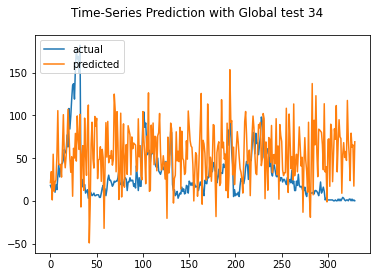

Test MAE: 35.939
Test RMSE: 46.529
Test sMAPE: 100.295
Test R Squared: -1.240
{'mae': 35.938837282585375, 'rmse': 46.529448319062254, 'smape': 100.29542305002066, 'r2': -1.2402568208461529}


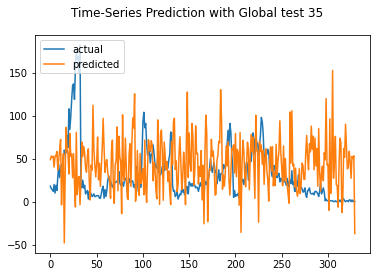

Test MAE: 52.675
Test RMSE: 62.960
Test sMAPE: 108.150
Test R Squared: -3.102
{'mae': 52.675276696501356, 'rmse': 62.959557225810514, 'smape': 108.15026485764163, 'r2': -3.1017135922153045}


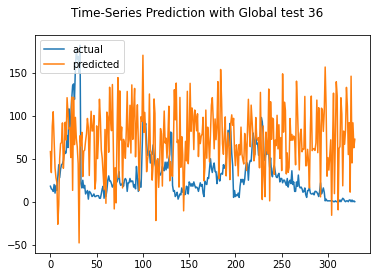

Test MAE: 45.098
Test RMSE: 54.099
Test sMAPE: 99.891
Test R Squared: -2.028
{'mae': 45.097890467354745, 'rmse': 54.09864979746262, 'smape': 99.8906720347319, 'r2': -2.0284112704188013}


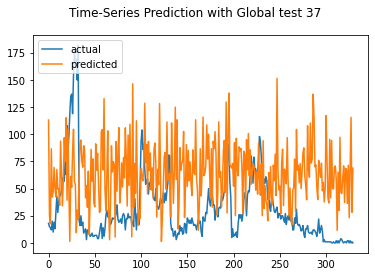

Test MAE: 45.617
Test RMSE: 57.017
Test sMAPE: 101.184
Test R Squared: -2.364
{'mae': 45.61728240143169, 'rmse': 57.01692334590492, 'smape': 101.18435727727007, 'r2': -2.3639502126167042}


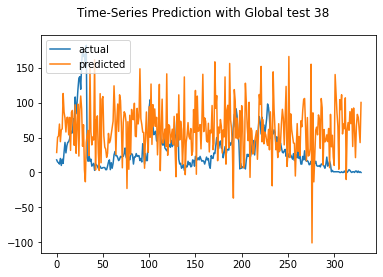

Test MAE: 43.519
Test RMSE: 52.815
Test sMAPE: 100.451
Test R Squared: -1.886
{'mae': 43.51902872432362, 'rmse': 52.815217586492025, 'smape': 100.45097210001407, 'r2': -1.8864241420037797}


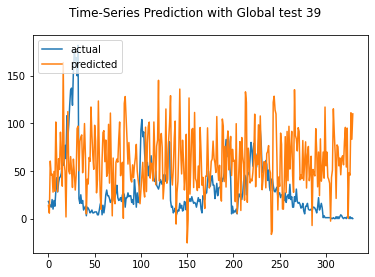

Test MAE: 77.187
Test RMSE: 84.588
Test sMAPE: 120.625
Test R Squared: -6.404
{'mae': 77.18745764530067, 'rmse': 84.5881029600123, 'smape': 120.62521035936456, 'r2': -6.403900473394253}


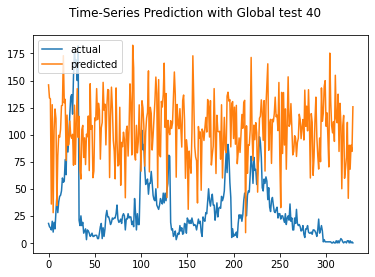

Test MAE: 46.167
Test RMSE: 55.326
Test sMAPE: 101.085
Test R Squared: -2.167
{'mae': 46.16697245438893, 'rmse': 55.32580423620804, 'smape': 101.08512145988865, 'r2': -2.167360330286667}


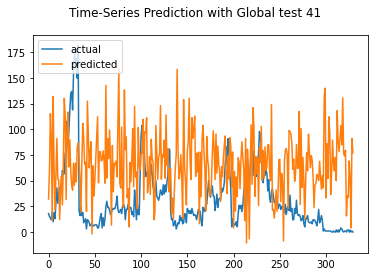

Test MAE: 43.603
Test RMSE: 52.709
Test sMAPE: 104.014
Test R Squared: -1.875
{'mae': 43.603136430003424, 'rmse': 52.708982662507, 'smape': 104.01358368142347, 'r2': -1.8748240513682637}


Test MAE: 45.230
Test RMSE: 56.302
Test sMAPE: 104.033
Test R Squared: -2.280
{'mae': 45.22955858779676, 'rmse': 56.302116592096205, 'smape': 104.03250392064781, 'r2': -2.28013293799085}


Test MAE: 43.912
Test RMSE: 53.649
Test sMAPE: 105.509
Test R Squared: -1.978
{'mae': 43.9119312260187, 'rmse': 53.648538598290244, 'smape': 105.50911520357126, 'r2': -1.9782269824429406}


Test MAE: 50.063
Test RMSE: 59.410
Test sMAPE: 105.475
Test R Squared: -2.652
{'mae': 50.06326688925425, 'rmse': 59.41004401620263, 'smape': 105.47473512118766, 'r2': -2.6522605304795617}


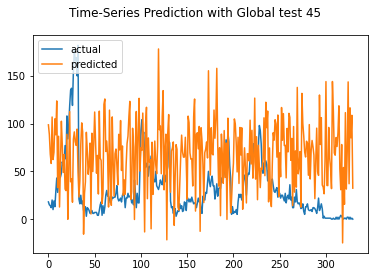

Test MAE: 53.917
Test RMSE: 63.488
Test sMAPE: 108.729
Test R Squared: -3.171
{'mae': 53.91728792389234, 'rmse': 63.487971384984746, 'smape': 108.72918190906569, 'r2': -3.1708531812095933}


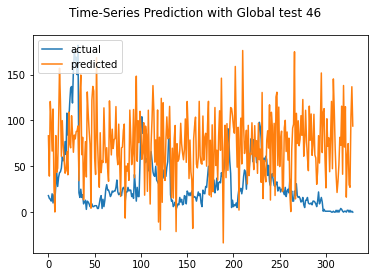

Test MAE: 50.987
Test RMSE: 59.366
Test sMAPE: 105.389
Test R Squared: -2.647
{'mae': 50.98675401373343, 'rmse': 59.36620760161984, 'smape': 105.38883963342421, 'r2': -2.6468727903142644}


Test MAE: 55.735
Test RMSE: 64.722
Test sMAPE: 107.997
Test R Squared: -3.335
{'mae': 55.73512041677128, 'rmse': 64.72192355524696, 'smape': 107.99693371282393, 'r2': -3.3345581540570954}


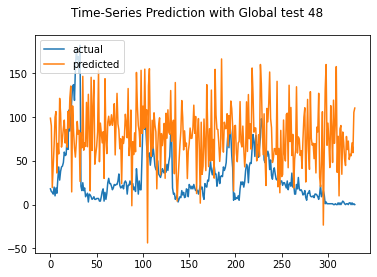

Test MAE: 52.176
Test RMSE: 62.121
Test sMAPE: 106.686
Test R Squared: -2.993
{'mae': 52.175503511681704, 'rmse': 62.12110505873495, 'smape': 106.68575200713562, 'r2': -2.993193422242146}


Test MAE: 47.692
Test RMSE: 56.363
Test sMAPE: 103.108
Test R Squared: -2.287
{'mae': 47.691595589392115, 'rmse': 56.362894402548534, 'smape': 103.10786770530888, 'r2': -2.2872185295687113}


Test MAE: 45.353
Test RMSE: 55.016
Test sMAPE: 104.215
Test R Squared: -2.132
{'mae': 45.352681396585524, 'rmse': 55.01641269398664, 'smape': 104.21480169495592, 'r2': -2.1320345190252903}


Test MAE: 51.576
Test RMSE: 59.879
Test sMAPE: 105.409
Test R Squared: -2.710
{'mae': 51.57598673502604, 'rmse': 59.878998030373026, 'smape': 105.40902824532643, 'r2': -2.710146433190111}


Test MAE: 37.223
Test RMSE: 46.952
Test sMAPE: 95.883
Test R Squared: -1.281
{'mae': 37.22289621107506, 'rmse': 46.952448621651605, 'smape': 95.88255765815241, 'r2': -1.2811744249702874}


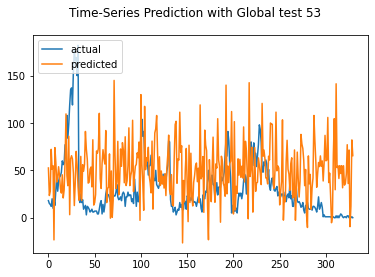

Test MAE: 47.487
Test RMSE: 55.793
Test sMAPE: 102.471
Test R Squared: -2.221
{'mae': 47.486606795318195, 'rmse': 55.793269807955, 'smape': 102.47064257220919, 'r2': -2.2211105503375834}


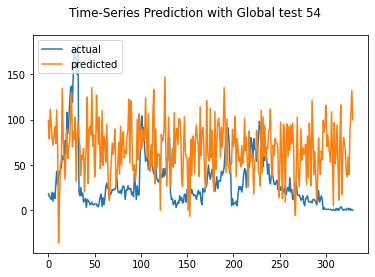

Test MAE: 46.041
Test RMSE: 56.144
Test sMAPE: 105.305
Test R Squared: -2.262
{'mae': 46.041315072955506, 'rmse': 56.14386090604726, 'smape': 105.30507651563447, 'r2': -2.2617190605281223}


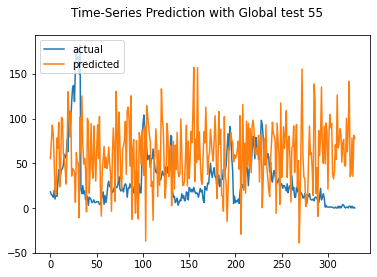

Test MAE: 41.424
Test RMSE: 49.824
Test sMAPE: 101.086
Test R Squared: -1.569
{'mae': 41.42415975350322, 'rmse': 49.82443347573549, 'smape': 101.086070802619, 'r2': -1.5687789886178072}


Test MAE: 44.312
Test RMSE: 54.067
Test sMAPE: 101.215
Test R Squared: -2.025
{'mae': 44.31161095373558, 'rmse': 54.066737852291894, 'smape': 101.21452407177156, 'r2': -2.024839499558281}


Test MAE: 67.878
Test RMSE: 75.817
Test sMAPE: 115.944
Test R Squared: -4.948
{'mae': 67.87786232919404, 'rmse': 75.81690282611845, 'smape': 115.94409880851165, 'r2': -4.948042734380666}


Test MAE: 65.685
Test RMSE: 76.924
Test sMAPE: 114.543
Test R Squared: -5.123
{'mae': 65.68519540772293, 'rmse': 76.92433384452131, 'smape': 114.54339152739952, 'r2': -5.123073739950284}


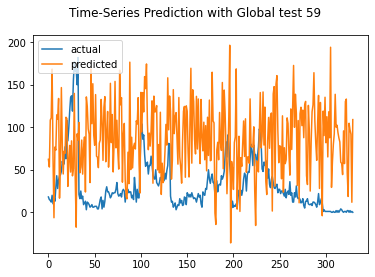

Test MAE: 40.110
Test RMSE: 49.994
Test sMAPE: 100.376
Test R Squared: -1.586
{'mae': 40.10965536742499, 'rmse': 49.99427470064696, 'smape': 100.37625998621394, 'r2': -1.5863217138053174}


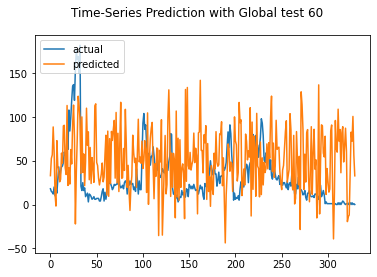

Test MAE: 56.815
Test RMSE: 65.031
Test sMAPE: 108.136
Test R Squared: -3.376
{'mae': 56.814591514703, 'rmse': 65.0308177350991, 'smape': 108.13574849767154, 'r2': -3.3760314231027344}


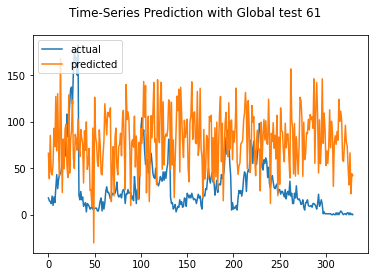

Test MAE: 45.625
Test RMSE: 54.683
Test sMAPE: 102.248
Test R Squared: -2.094
{'mae': 45.62461600719076, 'rmse': 54.683243141532515, 'smape': 102.24828012497969, 'r2': -2.0942152986217466}


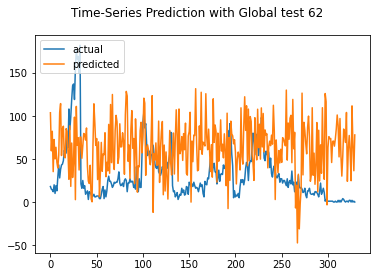

Test MAE: 44.960
Test RMSE: 54.147
Test sMAPE: 104.012
Test R Squared: -2.034
{'mae': 44.96020715814648, 'rmse': 54.14747520761435, 'smape': 104.01217620971826, 'r2': -2.0338801739198558}


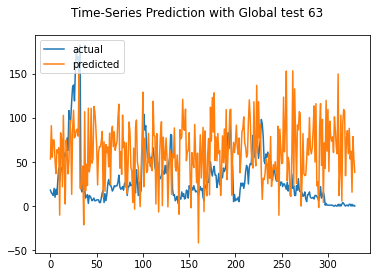

Test MAE: 60.522
Test RMSE: 68.423
Test sMAPE: 113.405
Test R Squared: -3.845
{'mae': 60.52239093347029, 'rmse': 68.42338171442205, 'smape': 113.40472846127143, 'r2': -3.8445235455256093}


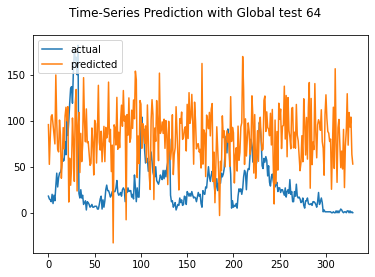

Test MAE: 48.013
Test RMSE: 57.087
Test sMAPE: 103.779
Test R Squared: -2.372
{'mae': 48.01285777760275, 'rmse': 57.08684728866246, 'smape': 103.77925652809276, 'r2': -2.3722061788203925}


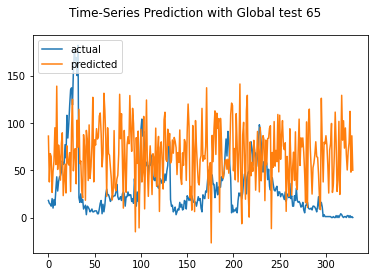

Test MAE: 44.418
Test RMSE: 53.023
Test sMAPE: 99.714
Test R Squared: -1.909
{'mae': 44.41812304222223, 'rmse': 53.02299761516733, 'smape': 99.714099669128, 'r2': -1.909179743050268}


Test MAE: 61.609
Test RMSE: 72.134
Test sMAPE: 113.513
Test R Squared: -4.384
{'mae': 61.60898944410411, 'rmse': 72.13406658119568, 'smape': 113.5129915022995, 'r2': -4.384220464828572}


Test MAE: 46.310
Test RMSE: 54.785
Test sMAPE: 106.046
Test R Squared: -2.106
{'mae': 46.31039965947469, 'rmse': 54.78522863896614, 'smape': 106.04625326779986, 'r2': -2.10576762567104}


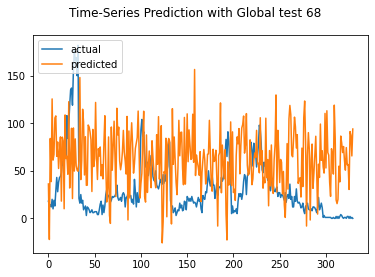

Test MAE: 39.548
Test RMSE: 49.041
Test sMAPE: 100.228
Test R Squared: -1.489
{'mae': 39.547964773214225, 'rmse': 49.04083820216597, 'smape': 100.22752544903426, 'r2': -1.488615321938199}


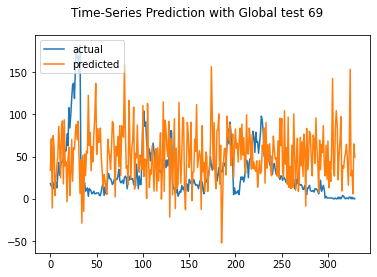

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 41.649
Test RMSE: 53.513
Test sMAPE: 114.980
Test R Squared: -1.963
{'mae': 41.64876635399732, 'rmse': 53.51290001975422, 'smape': 114.97986408635543, 'r2': -1.9631864307454827}


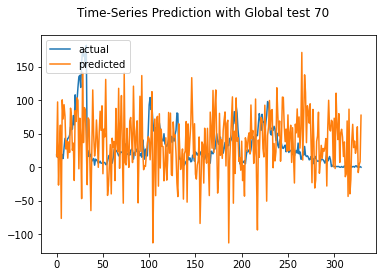

Test MAE: 46.687
Test RMSE: 57.064
Test sMAPE: 108.709
Test R Squared: -2.370
{'mae': 46.68680229494066, 'rmse': 57.06423284749599, 'smape': 108.70929990381858, 'r2': -2.369534969710544}


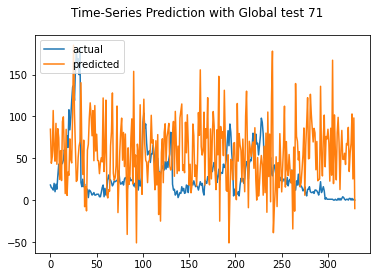

Test MAE: 41.092
Test RMSE: 50.515
Test sMAPE: 108.648
Test R Squared: -1.641
{'mae': 41.091618990175654, 'rmse': 50.515404491040044, 'smape': 108.64769324800251, 'r2': -1.6405212772882019}


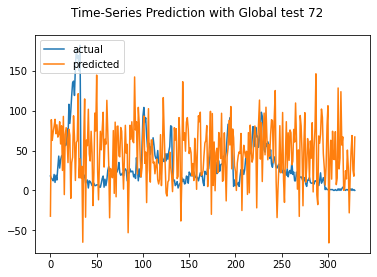

Test MAE: 53.881
Test RMSE: 62.580
Test sMAPE: 106.784
Test R Squared: -3.052
{'mae': 53.880605311827225, 'rmse': 62.58009057931833, 'smape': 106.78399960568309, 'r2': -3.0524193134372535}


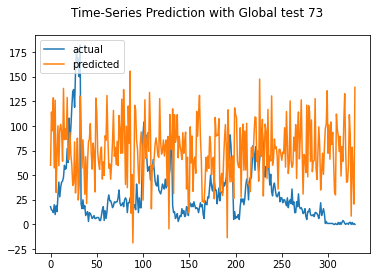

Test MAE: 58.893
Test RMSE: 69.140
Test sMAPE: 108.313
Test R Squared: -3.947
{'mae': 58.89311897971413, 'rmse': 69.14028792080933, 'smape': 108.312722192002, 'r2': -3.9465723906777512}


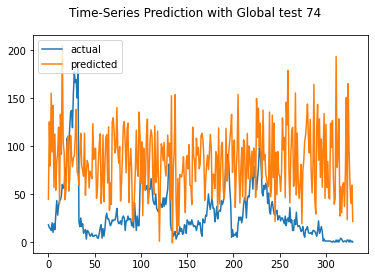

Test MAE: 50.168
Test RMSE: 60.363
Test sMAPE: 102.734
Test R Squared: -2.770
{'mae': 50.16818928899187, 'rmse': 60.36273557170647, 'smape': 102.73420449366081, 'r2': -2.7703340328662995}


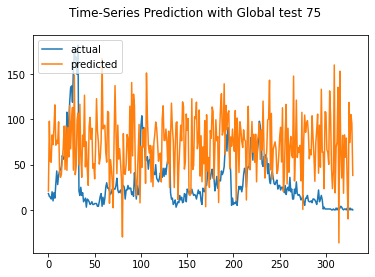

Test MAE: 57.702
Test RMSE: 65.727
Test sMAPE: 109.199
Test R Squared: -3.470
{'mae': 57.701784590518834, 'rmse': 65.7272350045456, 'smape': 109.19858216542295, 'r2': -3.4702594241492797}


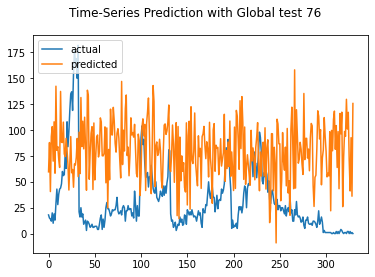

Test MAE: 53.555
Test RMSE: 64.051
Test sMAPE: 105.340
Test R Squared: -3.245
{'mae': 53.55499383752996, 'rmse': 64.05127888999692, 'smape': 105.34000221838936, 'r2': -3.2451946947543435}


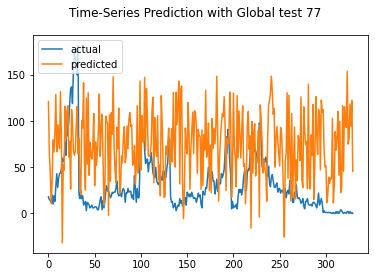

Test MAE: 62.567
Test RMSE: 71.256
Test sMAPE: 111.113
Test R Squared: -4.254
{'mae': 62.56697748429848, 'rmse': 71.25636133444888, 'smape': 111.11328579446585, 'r2': -4.253990519884992}


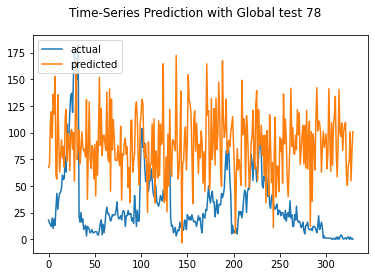

Test MAE: 46.958
Test RMSE: 55.896
Test sMAPE: 102.130
Test R Squared: -2.233
{'mae': 46.95798994916858, 'rmse': 55.89606814165038, 'smape': 102.12988675608597, 'r2': -2.232991189160536}


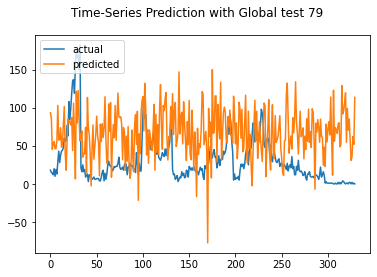

Test MAE: 46.092
Test RMSE: 55.199
Test sMAPE: 102.527
Test R Squared: -2.153
{'mae': 46.09166622089617, 'rmse': 55.19888875419048, 'smape': 102.52697962716212, 'r2': -2.1528453676440833}


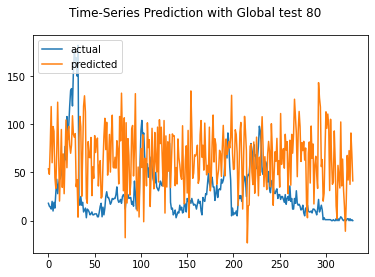

Test MAE: 34.504
Test RMSE: 44.001
Test sMAPE: 95.413
Test R Squared: -1.003
{'mae': 34.503716351588565, 'rmse': 44.00059724667166, 'smape': 95.41333797151793, 'r2': -1.0033606753113289}


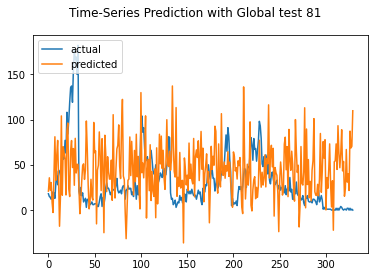

Test MAE: 41.611
Test RMSE: 50.136
Test sMAPE: 100.719
Test R Squared: -1.601
{'mae': 41.61118998166287, 'rmse': 50.13593464427679, 'smape': 100.71917022719477, 'r2': -1.6009992848253867}


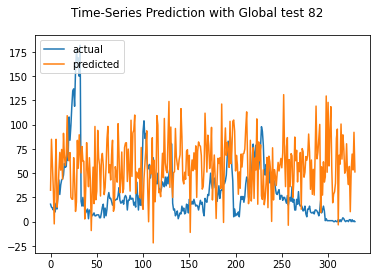

Test MAE: 73.368
Test RMSE: 82.922
Test sMAPE: 117.347
Test R Squared: -6.115
{'mae': 73.36765832034024, 'rmse': 82.92193867705072, 'smape': 117.34743688980463, 'r2': -6.115098159401865}


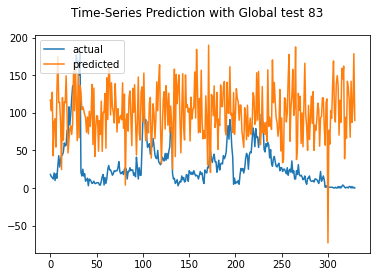

Test MAE: 46.017
Test RMSE: 54.227
Test sMAPE: 104.213
Test R Squared: -2.043
{'mae': 46.017112643429726, 'rmse': 54.22747322385752, 'smape': 104.21313478184224, 'r2': -2.0428513653351814}


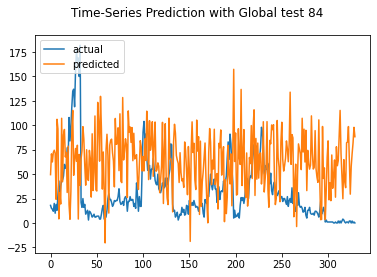

Test MAE: 38.903
Test RMSE: 47.154
Test sMAPE: 102.931
Test R Squared: -1.301
{'mae': 38.90263559619586, 'rmse': 47.15375900332649, 'smape': 102.93059798554208, 'r2': -1.3007776012866583}


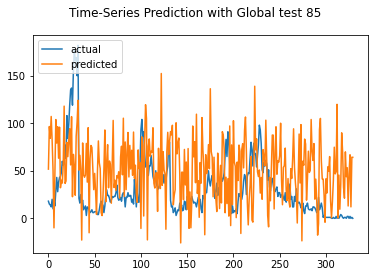

Test MAE: 41.208
Test RMSE: 50.758
Test sMAPE: 101.760
Test R Squared: -1.666
{'mae': 41.20783673271988, 'rmse': 50.757602037110686, 'smape': 101.76003499794183, 'r2': -1.6659020852706923}


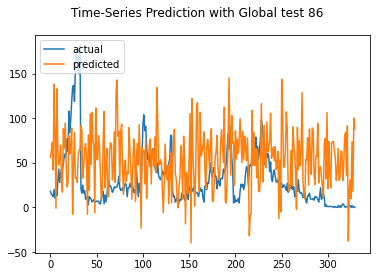

Test MAE: 43.243
Test RMSE: 52.631
Test sMAPE: 105.953
Test R Squared: -1.866
{'mae': 43.243424743504235, 'rmse': 52.63060583525474, 'smape': 105.95329515021936, 'r2': -1.8662808371142892}


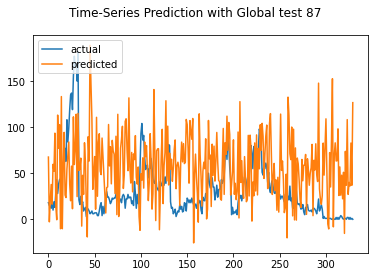

Test MAE: 54.595
Test RMSE: 63.642
Test sMAPE: 107.208
Test R Squared: -3.191
{'mae': 54.59501903201595, 'rmse': 63.64243079466227, 'smape': 107.2081038405826, 'r2': -3.1911723432273043}


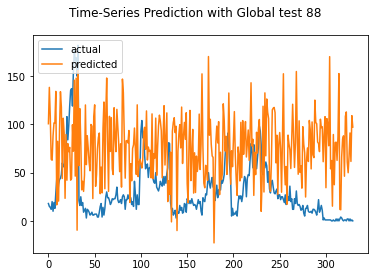

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 41.196
Test RMSE: 53.127
Test sMAPE: 115.313
Test R Squared: -1.921
{'mae': 41.196331087206346, 'rmse': 53.126795480874634, 'smape': 115.31253266578227, 'r2': -1.9205809171433077}


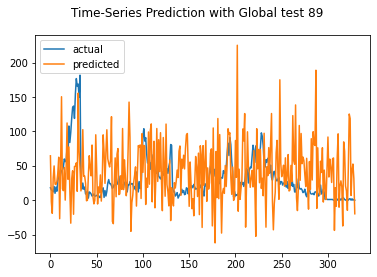

Test MAE: 61.114
Test RMSE: 70.126
Test sMAPE: 109.810
Test R Squared: -4.089
{'mae': 61.11379849982984, 'rmse': 70.12644107541128, 'smape': 109.80986465036165, 'r2': -4.0886853703232}


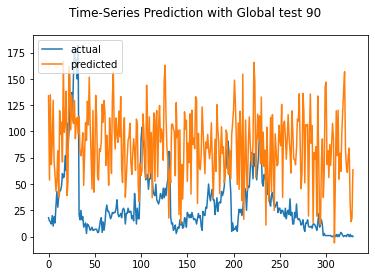

Test MAE: 38.254
Test RMSE: 49.028
Test sMAPE: 118.238
Test R Squared: -1.487
{'mae': 38.2539986614025, 'rmse': 49.02807781612282, 'smape': 118.23813693399019, 'r2': -1.487320419078368}


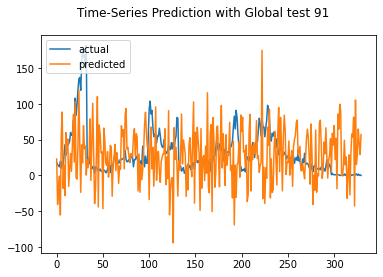

Test MAE: 53.020
Test RMSE: 61.895
Test sMAPE: 106.976
Test R Squared: -2.964
{'mae': 53.01971075769627, 'rmse': 61.894837116348846, 'smape': 106.97572280808048, 'r2': -2.9641570372383232}


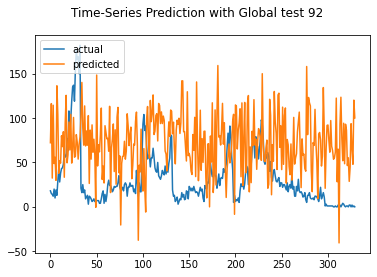

Test MAE: 60.788
Test RMSE: 70.978
Test sMAPE: 108.866
Test R Squared: -4.213
{'mae': 60.78805173671607, 'rmse': 70.97765145512167, 'smape': 108.86644048000599, 'r2': -4.212970314765045}


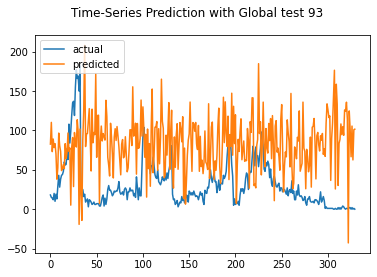

Test MAE: 57.843
Test RMSE: 66.631
Test sMAPE: 110.020
Test R Squared: -3.594
{'mae': 57.84306860006217, 'rmse': 66.63112578970427, 'smape': 110.01987712623013, 'r2': -3.5940562018372013}


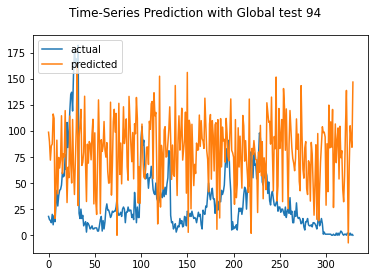

Test MAE: 49.365
Test RMSE: 60.548
Test sMAPE: 109.151
Test R Squared: -2.793
{'mae': 49.36486071384314, 'rmse': 60.547677205493684, 'smape': 109.1508351292772, 'r2': -2.793472809588495}


Test MAE: 63.012
Test RMSE: 70.984
Test sMAPE: 112.747
Test R Squared: -4.214
{'mae': 63.01208061738448, 'rmse': 70.98426997945728, 'smape': 112.74689161315756, 'r2': -4.213942558247632}


Test MAE: 38.290
Test RMSE: 50.265
Test sMAPE: 112.960
Test R Squared: -1.614
{'mae': 38.28983274156397, 'rmse': 50.26533000220927, 'smape': 112.9601051609159, 'r2': -1.6144423988121126}


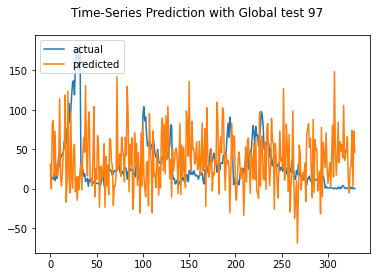

Test MAE: 46.818
Test RMSE: 55.596
Test sMAPE: 101.805
Test R Squared: -2.198
{'mae': 46.818456480358584, 'rmse': 55.59562561959706, 'smape': 101.80483867043105, 'r2': -2.1983298040313093}


Test MAE: 71.784
Test RMSE: 80.599
Test sMAPE: 116.332
Test R Squared: -5.722
{'mae': 71.78418889190212, 'rmse': 80.59943843332535, 'smape': 116.33157331079022, 'r2': -5.722116478590361}


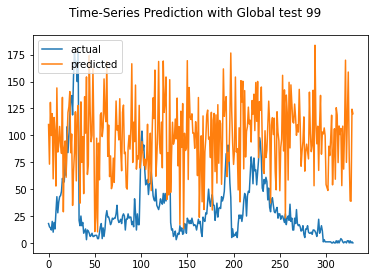

rmse : average=58.362, std=9.042
mae : average=48.901, std=9.295
smape : average=106.566, std=6.631
r2 : average=-2.609, std=1.166


([58.36243286950052, 9.041910054554354],
 [48.901452229673225, 9.29549883067012],
 [106.5659244534671, 6.631295093739141],
 [-2.609189836255386, 1.1663329782073486])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')